# Projet Télédétection Avancée UE:901_2  + Qualité et Fouille UE: 906

NOM: DIALLO
Prénom: Djiby

Données utilisées: Bretagne_24-25 et échantillons PI_strates_Bretagne_32630


# Introduction Générale

La classification d’images de télédétection constitue une étape clé pour transformer des données brutes en cartes thématiques exploitables. Elle permet d’identifier et de discriminer différents types de surfaces (sols nus, végétation, zones artificialisées, cultures, etc.) à partir de leurs signatures spectrales. Les méthodes de classification supervisée, et notamment celles basées sur l’apprentissage automatique, offrent aujourd’hui des performances élevées et une grande capacité de généralisation, à condition d’être correctement paramétrées et validées.

Ce projet s’inscrit dans cette dynamique et vise à mettre en œuvre une chaîne complète de traitement d’images allant du prétraitement des données jusqu’à la production d’une image classifiée finale constituée des classes comme du sol nu, herbe, landes et arbre. Il mobilise des outils de traitement numérique et des bibliothèques scientifiques afin de manipuler les données raster, entraîner un modèle de classification, évaluer l’importance des variables utilisées et générer une sortie cartographique cohérente et exploitable dans un SIG.

Une attention particulière est portée à la gestion des valeurs NoData, à la cohérence radiométrique et à la compatibilité des résultats avec les logiciels de cartographie tels que QGIS. L’objectif final est de produire une carte fiable et interprétable, tout en respectant les bonnes pratiques en télédétection et en traitement des données géospatiales.

Ce travail permet ainsi de consolider des compétences à la fois théoriques et pratiques en télédétection, en analyse spatiale et en programmation appliquée, tout en répondant à des enjeux concrets de production et de qualité de l’information géographique.

### IMPORTS ET CONFIGURATION

In [44]:
import sys
sys.path.append("/home/onyxia/work")

import sys
import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
from osgeo import gdal
from libsigma import read_and_write as rw

from libsigma import read_and_write as rw
from libsigma import plots

# Import scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Ma fonction personnel
import my_function as mf

### Définition des chemins

In [45]:
# Définition des chemins
BASE = "/home/onyxia/work"
DATA = os.path.join(BASE, "data", "projet_eval")
RESULTS = os.path.join(BASE, "results")
FIG = os.path.join(RESULTS, "figure")

# Création des dossiers si nécessaire
os.makedirs(RESULTS, exist_ok=True)
os.makedirs(FIG, exist_ok=True)
sortie_matrix = os.path.join(FIG, "matrice_confusion.png")
sortie_qualite = os.path.join(FIG, "qualite_classes.png")

# Chemins des données
vector_samples = os.path.join(DATA, "PI_strates_bretagne_32630.shp")
ref_image = os.path.join(DATA, "bretagne_24-25_B03.tif")

# Configuration
bandes_classif = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

DATES_BRETAGNE_24_25 = [
    "2025-03-31", "2025-04-10", "2025-05-15",
    "2025-06-17", "2025-07-12", "2025-08-10"
]

# Dictionnaires pour les classes
class_names = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}
color_map = {2: "limegreen", 3: "purple", 4: "darkgreen"}

print("✅ Configuration terminée")
print(f" Données : {DATA}")
print(f" Résultats : {RESULTS}")



✅ Configuration terminée
 Données : /home/onyxia/work/data/projet_eval
 Résultats : /home/onyxia/work/results


### Avant d’entraîner un modèle de classification supervisée, il est essentiel d’analyser la distribution des échantillons disponibles afin d’évaluer la représentativité des classes et d’anticiper d’éventuels déséquilibres pouvant influencer l’apprentissage.

# PARTIE 1 - ANALYSE DES ÉCHANTILLONS

### Comptage des polygones par classe

In [46]:
gdf = gpd.read_file(vector_samples)
print(gdf.head())
counts_poly = gdf["strate"].value_counts().sort_index()

classes = counts_poly.index.tolist()
values = counts_poly.values
print(counts_poly)

   id  strate      comment                                           geometry
0   1       3  lande basse  POLYGON ((441224.58 5366298.317, 441224.779 53...
1   2       3  lande basse  POLYGON ((441649.972 5366251.139, 441650.172 5...
2   3       3  lande basse  POLYGON ((441383.597 5366193.034, 441384.395 5...
3   4       2         None  POLYGON ((441336.658 5366402.088, 441337.257 5...
4   5       2         None  POLYGON ((441062.121 5366343.165, 441062.919 5...
strate
2     86
3    121
4     71
Name: count, dtype: int64


### Création du diagramme en bâtons - Polygones

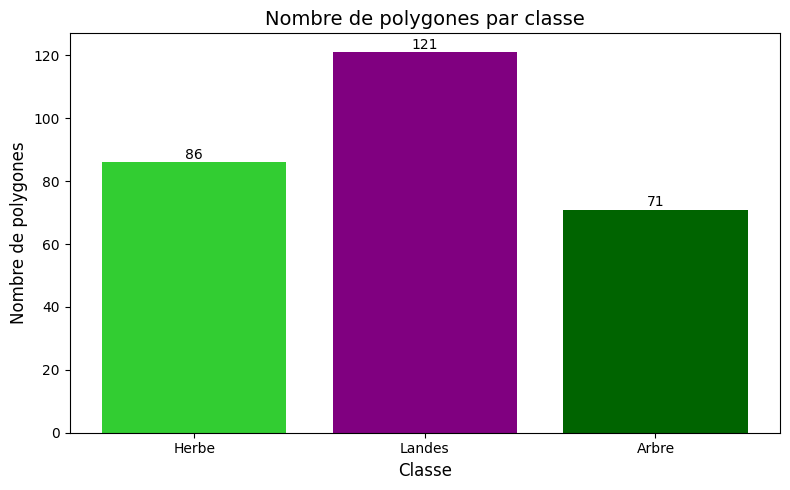

✅ Graphique sauvegardé : /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png


In [47]:
plt.figure(figsize=(8, 5))
classes_poly = counts_poly.index.tolist()
values_poly = counts_poly.values

# Filtrer les classes présentes
labels_poly = []
colors_poly = []
values_filtered = []

for c in classes_poly:
    if c in class_names and c in color_map:
        labels_poly.append(class_names[c])
        colors_poly.append(color_map[c])
        values_filtered.append(counts_poly[c])

bars = plt.bar(labels_poly, values_filtered, color=colors_poly)

plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre de polygones", fontsize=12)
plt.title("Nombre de polygones par classe", fontsize=14)

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
output_poly = os.path.join(FIG, "diag_baton_nb_poly_by_class.png")
plt.savefig(output_poly, dpi=150)
plt.show()
print(f"✅ Graphique sauvegardé : {output_poly}")

###  Note sur la nomenclature

Analyse des polygones d’échantillons

Le diagramme en bâtons met en évidence la présence de trois classes seulement dans les échantillons disponibles :
– classe 2 (Herbe),
– classe 3 (Landes),
– classe 4 (Arbre).

La classe 1 (Sol Nu) est absente de la base d’échantillons. Cette absence est cohérente avec le contexte breton, caractérisé par une forte couverture végétale permanente et peu de surfaces minérales nues.

En conséquence, la classification supervisée sera limitée à ces trois classes, et aucune prédiction de la classe Sol Nu ne sera possible.

#  PARTIE 2 — RASTERISATION DES ÉCHANTILLONS

###  Rasterisation

In [48]:
out_raster = os.path.join(RESULTS, "strates_rasterise.tif")

mf.rasterize_vector(
    vector_path=vector_samples,
    ref_raster_path=ref_image,   # ✅ utiliser la variable existante
    output_path=out_raster,
    attribute="strate"
)

print("Raster créé :", out_raster)



✅ Rasterisation terminée : /home/onyxia/work/results/strates_rasterise.tif
Raster créé : /home/onyxia/work/results/strates_rasterise.tif


Les polygones d’échantillons sont rasterisés à la résolution spatiale de 10 m, en utilisant la bande B03 comme image de référence pour garantir la cohérence géométrique (projection, emprise et taille de pixel).
Les pixels non échantillonnés sont codés à 0 (nodata).

### Comptage des pixels par classe

In [49]:
arr = rw.load_img_as_array(out_raster).squeeze()

vals, counts = np.unique(arr[arr > 0], return_counts=True)

print("\nNombre de pixels par classe :")
for v, c in zip(vals, counts):
    print(f"Classe {v} : {c} pixels")




Nombre de pixels par classe :
Classe 2 : 1022 pixels
Classe 3 : 1599 pixels
Classe 4 : 1218 pixels


### Création du diagramme en bâtons - Pixels

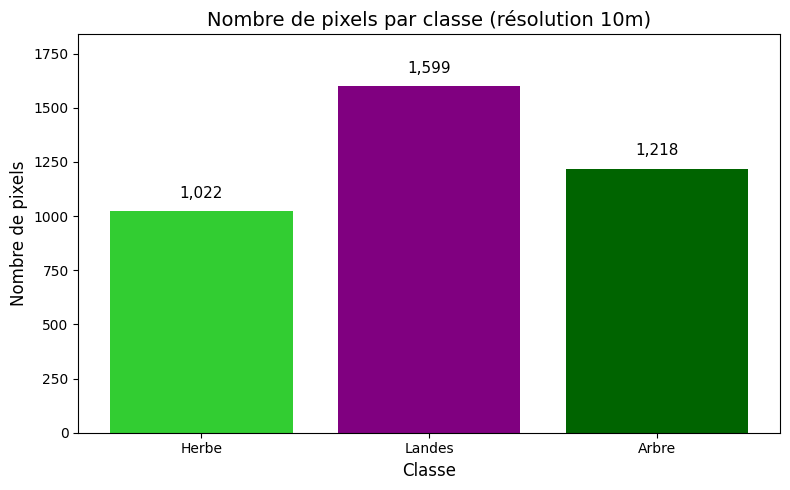

✅ Graphique sauvegardé : /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png


In [50]:
plt.figure(figsize=(8, 5))

labels_pix = [class_names[c] for c in vals]
colors_pix = [color_map[c] for c in vals]
counts_pix = counts

bars = plt.bar(labels_pix, counts_pix, color=colors_pix)

plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre de pixels", fontsize=12)
plt.title("Nombre de pixels par classe (résolution 10m)", fontsize=14)

offset = 0.03 * max(counts_pix)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + offset,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.ylim(0, max(counts_pix) * 1.15)

plt.tight_layout()

output_pix = os.path.join(FIG, "diag_baton_nb_pix_by_class.png")
plt.savefig(output_pix, dpi=150)
plt.show()

print(f"✅ Graphique sauvegardé : {output_pix}")


Les classes ne sont pas parfaitement équilibrées en nombre de pixels. La classe Landes est la plus représentée, ce qui pourra influencer l’apprentissage du classifieur supervisé et justifie l’utilisation d’une métrique pondérée lors de l’optimisation.

# PARTIE 3A - CALCUL DE L'INDICE ARI

### SÉLECTION DES BANDES B03 ET B05

In [51]:
# Les fichiers Sentinel-2 fournis sont déjà des séries temporelles :
# chaque bande du GeoTIFF correspond à une date de la série
stack_B03 = DATA + "/bretagne_24-25_B03.tif"
stack_B05 = DATA + "/bretagne_24-25_B05.tif"

# Chargement
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

print("Shape B03 :", B03.shape)
print("Shape B05 :", B05.shape)



Shape B03 : (612, 1533, 6)
Shape B05 : (612, 1533, 6)


Les bandes B03 (vert, 560 nm) et B05 (red-edge, 705 nm) sont utilisées pour le calcul de l'indice ARI (Anthocyanin Reflectance Index).

La bande red-edge est particulièrement sensible à la présence d'anthocyanes, pigments caractéristiques de certaines landes à Éricacées, notamment en automne.

### Chargement et calcul de l'ARI

In [52]:
stack_B03 = os.path.join(DATA, "bretagne_24-25_B03.tif")
stack_B05 = os.path.join(DATA, "bretagne_24-25_B05.tif")

print("Chargement des bandes B03 et B05...")
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

print(f"  Shape B03 : {B03.shape}")
print(f"  Shape B05 : {B05.shape}")

# Calcul de l'ARI a
print(" Calcul de l'ARI...")
ARI = mf.calculate_ari(B03, B05, nodata=-9999)

print(f"  Shape ARI : {ARI.shape}")
print(f"  Valeurs min/max : {np.nanmin(ARI[ARI != -9999]):.3f} / {np.nanmax(ARI[ARI != -9999]):.3f}")

Chargement des bandes B03 et B05...
  Shape B03 : (612, 1533, 6)
  Shape B05 : (612, 1533, 6)
 Calcul de l'ARI...
  Shape ARI : (612, 1533, 6)
  Valeurs min/max : -0.594 / 0.488


### Sauvegarde de la série temporelle ARI

In [53]:
out_ARI = RESULTS + "/ARI_serie_temp.tif"
ds_ref = gdal.Open(stack_B03)
driver = gdal.GetDriverByName("GTiff")

rows, cols, nb_dates = ARI.shape

ds_out = driver.Create(out_ARI, cols, rows, nb_dates, gdal.GDT_Float32)
ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

for i in range(nb_dates):
    band = ds_out.GetRasterBand(i+1)
    band.WriteArray(ARI[:,:,i])
    band.SetNoDataValue(-9999)

ds_out = None
ds_ref = None

print("Série temporelle ARI sauvegardée")

Série temporelle ARI sauvegardée


### Vérification des caractéristiques du raster ARI créé

In [54]:
ds = gdal.Open(out_ARI)

gt = ds.GetGeoTransform()

print("Résolution X :", gt[1])
print("Résolution Y :", abs(gt[5]))
print("Projection :", ds.GetProjection())
print("Type :", gdal.GetDataTypeName(ds.GetRasterBand(1).DataType))
print("NoData :", ds.GetRasterBand(1).GetNoDataValue())

ds = None

Résolution X : 10.0
Résolution Y : 10.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
Type : Float32
NoData : -9999.0


# PARTIE 3B - ANALYSE PHÉNOLOGIQUE

### Extraction des statistiques par classe

In [55]:
# Extraction des statistiques ARI par classe

ARI_loaded = rw.load_img_as_array(out_ARI)
strates = rw.load_img_as_array(out_raster).squeeze()

classes = [2, 3, 4]  # Herbe, Landes, Arbre
nb_classes = len(classes)
nb_dates = ARI_loaded.shape[2]

# Initialisation des tableaux
moyennes = np.zeros((nb_classes, nb_dates))
ecarts_types = np.zeros((nb_classes, nb_dates))

# Calcul des statistiques
for i, classe in enumerate(classes):
    mask_classe = (strates == classe)

    for d in range(nb_dates):
        valeurs = ARI_loaded[:, :, d][mask_classe]
        valeurs = valeurs[valeurs != -9999]

        if valeurs.size > 0:
            moyennes[i, d] = np.mean(valeurs)
            ecarts_types[i, d] = np.std(valeurs)
        else:
            moyennes[i, d] = np.nan
            ecarts_types[i, d] = np.nan

print("Statistiques ARI calculées pour chaque classe et chaque date")


Statistiques ARI calculées pour chaque classe et chaque date


### Création du graphique de phénologie

La figure suivante présente l’évolution temporelle de l’indice ARI moyen par strate, ainsi que l’écart-type intra-classe. L’objectif est d’évaluer la capacité de l’ARI à discriminer la classe Landes.


=== Statistiques globales ARI par strate ===
Strate 2:
  min : 0.053645983
  max : 0.22484577
  mean: 0.15296303
  std : 0.02722788
Strate 3:
  min : 0.03926704
  max : 0.25989395
  mean: 0.14291848
  std : 0.021305667
Strate 4:
  min : 0.025869751
  max : 0.25177497
  mean: 0.11744908
  std : 0.029166808


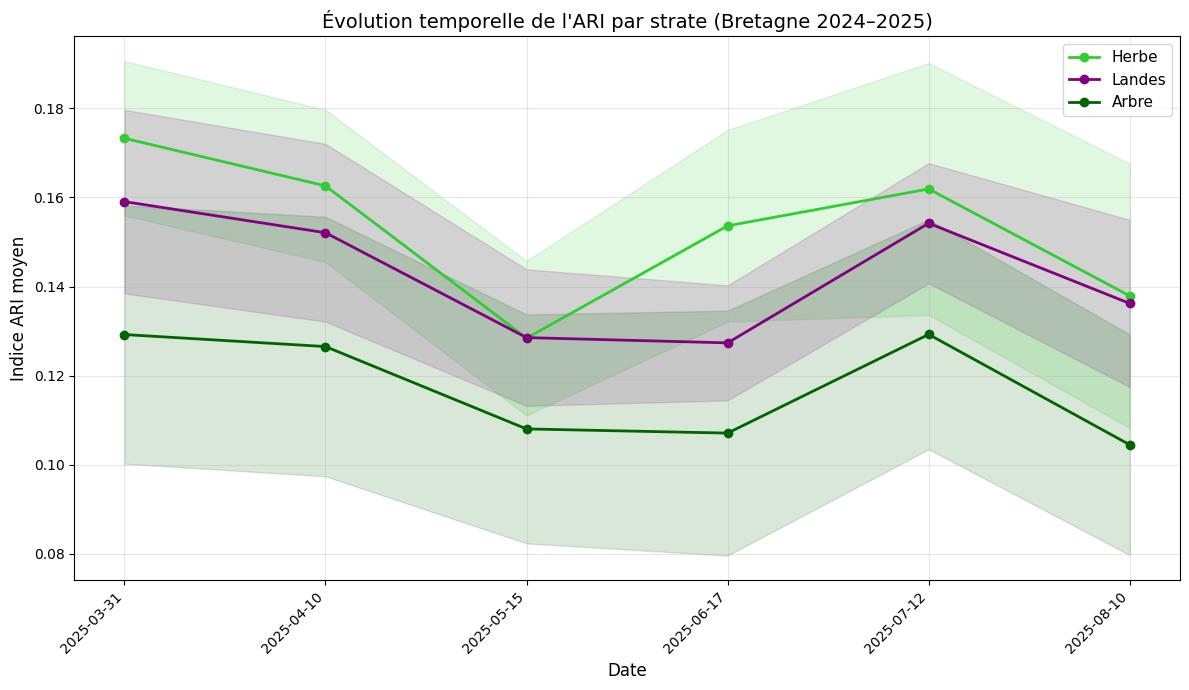

In [56]:
# Dates correspondant aux 6 acquisitions Sentinel-2 de la série Bretagne 2024–2025
dates = ["2025-03-31", "2025-04-10", "2025-05-15", 
         "2025-06-17", "2025-07-12", "2025-08-10"]

plt.figure(figsize=(12, 7))

labels = ["Herbe", "Landes", "Arbre"]
colors = ["limegreen", "purple", "darkgreen"]

print("\n=== Statistiques globales ARI par strate ===")

for i, classe in enumerate(classes):
    mask_classe = (strates == classe)

    valeurs_classe = ARI_loaded[mask_classe]
    valeurs_classe = valeurs_classe[valeurs_classe != -9999]

    print(f"Strate {classe}:")
    print("  min :", np.nanmin(valeurs_classe))
    print("  max :", np.nanmax(valeurs_classe))
    print("  mean:", np.nanmean(valeurs_classe))
    print("  std :", np.nanstd(valeurs_classe))


for i in range(3):
    plt.plot(dates, moyennes[i, :],
             label=labels[i],
             color=colors[i],
             marker='o',
             linewidth=2,
             markersize=6)

    plt.fill_between(dates,
                     moyennes[i, :] - ecarts_types[i, :],
                     moyennes[i, :] + ecarts_types[i, :],
                     alpha=0.15,
                     color=colors[i])

plt.xlabel("Date", fontsize=12)
plt.ylabel("Indice ARI moyen", fontsize=12)
plt.title("Évolution temporelle de l'ARI par strate (Bretagne 2024–2025)", fontsize=14)
plt.legend(loc="best", fontsize=11)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG + "/ARI_series.png", dpi=150, bbox_inches="tight")
plt.show()

### Analyse de la phénologie ARI

Les valeurs moyennes de l’ARI varient globalement entre 0.10 et 0.18 pour l’ensemble des strates étudiées. Les écarts-types observés traduisent une variabilité intra-classe non négligeable, en particulier pour les classes Herbe et Landes.

La classe Herbe présente les valeurs d’ARI les plus élevées sur l’ensemble de la période, avec un maximum observé en été. La classe Landes montre un comportement temporel proche de celui de l’Herbe, avec des valeurs intermédiaires. À l’inverse, la classe Arbre présente des valeurs plus faibles et relativement plus stables dans le temps.

La classe Landes ne se distingue pas clairement des autres strates sur la base de l’ARI seul. La forte similarité de son profil temporel avec celui de l’Herbe suggère des confusions potentielles entre ces deux classes.

On observe une dynamique saisonnière marquée, avec un minimum au printemps (mai–juin) et un maximum en été (juillet), cohérente avec les cycles de végétation.

En conclusion, l’ARI seul ne permet pas une discrimination satisfaisante des Landes. Une approche multivariée intégrant l’ensemble des bandes spectrales et la dimension temporelle apparaît nécessaire pour améliorer la classification.

# PARTIE 4 - CLASSIFICATION SUPERVISÉE

### Fusion des bandes spectrales Sentinel-2

In [57]:
tif_list = [
    DATA + "/bretagne_24-25_B02.tif",
    DATA + "/bretagne_24-25_B03.tif",
    DATA + "/bretagne_24-25_B04.tif",
    DATA + "/bretagne_24-25_B05.tif",
    DATA + "/bretagne_24-25_B06.tif",
    DATA + "/bretagne_24-25_B07.tif",
    DATA + "/bretagne_24-25_B08.tif",
    DATA + "/bretagne_24-25_B8A.tif",
    DATA + "/bretagne_24-25_B11.tif",
    DATA + "/bretagne_24-25_B12.tif",
]

stack = []

for tif in tif_list:
    ds = gdal.Open(tif)
    arr = ds.ReadAsArray()              # (dates, rows, cols)
    arr = np.transpose(arr, (1, 2, 0))  # (rows, cols, dates)
    stack.append(arr)

image_stack = np.concatenate(stack, axis=2)

print("Stack spectral :", image_stack.shape)  # (rows, cols, 60)


Stack spectral : (612, 1533, 60)


### Sauvegarde du raster multibande final

In [58]:
out_stack = RESULTS + "/bretagne_stack_spectral.tif"

mf.save_multiband_raster(
    image_stack,
    tif_list[0],
    out_stack,
    nodata=-9999
)

print("Raster multibande sauvegardé :", out_stack)

output_multibande = out_stack


✅ Raster multibande sauvegardé : /home/onyxia/work/results/bretagne_stack_spectral.tif
Raster multibande sauvegardé : /home/onyxia/work/results/bretagne_stack_spectral.tif


### Vérification des bandes

In [59]:
ds = gdal.Open(output_multibande)
print("Nombre de bandes :", ds.RasterCount)
ordered_bands = []

for b in ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]:
    for d in range(1, 7):
        ordered_bands.append(f"{b}_t{d}")
for i in range(1, ds.RasterCount + 1):
    arr = ds.GetRasterBand(i).ReadAsArray().astype("float32")
    arr[arr == -9999] = np.nan

    print(
        f"Bande {i:02d} ({ordered_bands[i-1]}): "
        f"min={np.nanmin(arr):.3f}, "
        f"max={np.nanmax(arr):.3f}, "
        f"mean={np.nanmean(arr):.3f}"
    )

ds = None


Nombre de bandes : 60
Bande 01 (B02_t1): min=1040.000, max=5144.000, mean=1398.158
Bande 02 (B02_t2): min=1133.000, max=4740.000, mean=1476.020
Bande 03 (B02_t3): min=763.000, max=18816.000, mean=1416.091
Bande 04 (B02_t4): min=1027.000, max=6680.000, mean=1334.132
Bande 05 (B02_t5): min=998.000, max=4776.000, mean=1334.678
Bande 06 (B02_t6): min=1072.000, max=5944.000, mean=1358.103
Bande 07 (B03_t1): min=1091.000, max=5332.000, mean=1655.757
Bande 08 (B03_t2): min=1176.000, max=5108.000, mean=1736.609
Bande 09 (B03_t3): min=1129.000, max=14744.000, mean=1682.440
Bande 10 (B03_t4): min=1031.000, max=9376.000, mean=1622.792
Bande 11 (B03_t5): min=1100.000, max=5220.000, mean=1603.801
Bande 12 (B03_t6): min=1135.000, max=6248.000, mean=1612.979
Bande 13 (B04_t1): min=1074.000, max=5340.000, mean=1656.484
Bande 14 (B04_t2): min=1131.000, max=5144.000, mean=1703.061
Bande 15 (B04_t3): min=1075.000, max=6560.000, mean=1512.534
Bande 16 (B04_t4): min=1007.000, max=10520.000, mean=1470.885
B

### Préparation des données d’apprentissage

In [60]:
X_image = rw.load_img_as_array(out_stack)
y_raster = rw.load_img_as_array(out_raster).squeeze()

X, Y, mask = mf.prepare_training_data(X_image, y_raster)
Y = Y.ravel()

print("X shape :", X.shape)
print("Y shape :", Y.shape)
print("Classes :", np.unique(Y))


X shape : (3839, 60)
Y shape : (3839,)
Classes : [2 3 4]


### Séparation apprentissage / test

In [61]:
# Split stratifié train / test (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    stratify=Y,        # conserve proportions des classes
    random_state=42
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)

# Vérification distribution des classes
print("\nDistribution classes TRAIN:")
for c, n in zip(*np.unique(y_train, return_counts=True)):
    print(f"Classe {c} : {n}")

print("\nDistribution classes TEST:")
for c, n in zip(*np.unique(y_test, return_counts=True)):
    print(f"Classe {c} : {n}")


Train : (2687, 60) (2687,)
Test  : (1152, 60) (1152,)

Distribution classes TRAIN:
Classe 2 : 715
Classe 3 : 1119
Classe 4 : 853

Distribution classes TEST:
Classe 2 : 307
Classe 3 : 480
Classe 4 : 365


### GridSearch

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

# ============================
# Définition du modèle
# ============================

rf_base = RandomForestClassifier(
    random_state=0,
    n_jobs=-1
)

# ============================
# Grille d’hyperparamètres
# ============================

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 10, 15, 20],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_leaf": [1, 5],
}

# ============================
# Validation croisée stratifiée
# ============================

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=0
)

# ============================
# GridSearch
# ============================

grid = GridSearchCV(
    estimator= rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_weighted",   # adapté aux classes déséquilibrées
    n_jobs=-1,
    verbose=2
)

print("🚀 Lancement du GridSearch...")
grid.fit(X_train, y_train)

# ============================
# Résultats CV
# ============================

print("\nMeilleurs hyperparamètres trouvés :")
print(grid.best_params_)

print(f"Score CV moyen (F1 pondéré) : {grid.best_score_:.3f}")

# ============================
# Modèle final
# ============================

best_model = grid.best_estimator_

# ============================
# Évaluation sur jeu de test
# ============================

y_pred = best_model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
f1_test  = f1_score(y_test, y_pred, average="weighted")

print("\n=== Évaluation sur le jeu de test ===")
print(f"Accuracy test : {acc_test:.3f}")
print(f"F1 pondéré test : {f1_test:.3f}")


🚀 Lancement du GridSearch...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  11.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.6s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  18.6s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  19.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  19.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  20.4s
[CV]

### Validation croisée stratifié

In [65]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

list_acc = []
list_f1 = []
list_cm = []
list_report = []

print("\n=== Validation croisée (5 folds) ===")

for fold, (train_idx, val_idx) in enumerate(cv.split(X, Y.ravel())):
    X_train_cv = X[train_idx]
    y_train_cv = Y.ravel()[train_idx]
    X_val_cv = X[val_idx]
    y_val_cv = Y.ravel()[val_idx]
    
    # Entraînement
    best_model.fit(X_train_cv, y_train_cv)
    
    # Prédiction
    y_pred_cv = best_model.predict(X_val_cv)
    
    # Métriques
    acc = accuracy_score(y_val_cv, y_pred_cv)
    f1 = f1_score(y_val_cv, y_pred_cv, average='weighted')
    cm = confusion_matrix(y_val_cv, y_pred_cv)
    report = classification_report(y_val_cv, y_pred_cv, output_dict=True)
    
    list_acc.append(acc)
    list_f1.append(f1)
    list_cm.append(cm)
    list_report.append(pd.DataFrame(report).T)
    
    print(f"Fold {fold+1}: Acc={acc:.3f}, F1={f1:.3f}")



=== Validation croisée (5 folds) ===
Fold 1: Acc=0.970, F1=0.970
Fold 2: Acc=0.987, F1=0.987
Fold 3: Acc=0.973, F1=0.973
Fold 4: Acc=0.984, F1=0.984
Fold 5: Acc=0.969, F1=0.969


### Calcul des moyennes

In [66]:
mean_accuracy = np.mean(list_acc)
std_accuracy = np.std(list_acc)
mean_f1 = np.mean(list_f1)
std_f1 = np.std(list_f1)

print(f"\n=== Résultats validation croisée ===")
print(f"Accuracy moyenne : {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"F1 pondéré moyen : {mean_f1:.3f} ± {std_f1:.3f}")


=== Résultats validation croisée ===
Accuracy moyenne : 0.977 ± 0.008
F1 pondéré moyen : 0.977 ± 0.008


### Importance des variables

In [67]:
feature_names = []

# bandes spectrales
for bande in bandes_classif:
    for date in DATES_BRETAGNE_24_25:
        feature_names.append(f"{bande}_{date}")


print("Nombre de variables :", len(feature_names))
print("Nombre d'importances :", len(best_model.feature_importances_))


# Tableau des importances
importances = best_model.feature_importances_

df_importance = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 des variables les plus importantes :")
print(df_importance.head(10).to_string(index=False))

Nombre de variables : 60
Nombre d'importances : 60

Top 10 des variables les plus importantes :
      Variable  Importance
B08_2025-04-10    0.069463
B07_2025-04-10    0.058990
B05_2025-06-17    0.057259
B08_2025-03-31    0.049972
B8A_2025-04-10    0.047904
B04_2025-05-15    0.043851
B06_2025-03-31    0.040430
B05_2025-08-10    0.040402
B12_2025-05-15    0.038419
B8A_2025-03-31    0.036119


### Graphique importance des variables

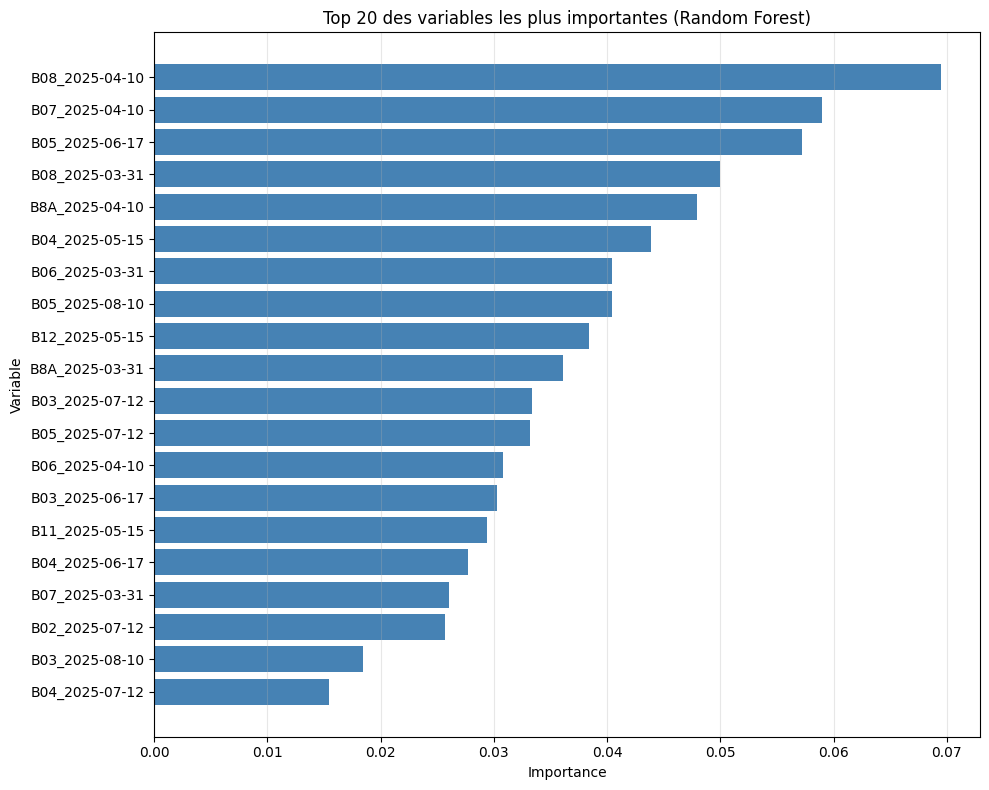

Figure importance sauvegardée : /home/onyxia/work/results/figure/feature_importance.png


In [68]:
plt.figure(figsize=(10, 8))
top_20 = df_importance.head(20)

plt.barh(top_20["Variable"], top_20["Importance"], color="steelblue")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.title("Top 20 des variables les plus importantes (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()

output_importance = os.path.join(FIG, "feature_importance.png")
plt.savefig(output_importance, dpi=150)
plt.show()

print(f"Figure importance sauvegardée : {output_importance}")


L’analyse de l’importance des variables montre que les bandes red-edge (B06, B07, B05, B8A) sont les plus contributives à la classification, suivies des bandes rouge (B04), proche infrarouge (B08) et SWIR (B11, B12).

Ce résultat est cohérent avec la littérature, ces longueurs d’onde étant particulièrement sensibles à la teneur en chlorophylle, à la structure de la végétation et à la biomasse, paramètres essentiels pour discriminer les strates herbacées, les landes et les formations arborées.

À l’inverse, les bandes visibles bleue (B02) et verte (B03) présentent une contribution plus faible, ce qui est attendu pour des classes dominées par la végétation.

### Exactitude globale moyenne + écart-type

In [69]:
array_report = np.array(list_report)

mean_report = array_report.mean(axis=0)
std_report  = array_report.std(axis=0)

array_cm = np.array(list_cm)

print("Accuracy moyenne :", mean_accuracy)
print("Écart-type accuracy :", std_accuracy)



Accuracy moyenne : 0.97655435136897
Écart-type accuracy : 0.0076007829989222135


In [70]:
# Matrice cumulée (recommandée)
sum_cm = array_cm.sum(axis=0)

# Matrice moyenne arrondie (option rapport)
mean_cm = np.rint(array_cm.mean(axis=0)).astype(int)

array_acc = np.array(list_acc)
mean_accuracy = array_acc.mean()
std_accuracy = array_acc.std()

print("Accuracy moyenne :", mean_accuracy)
print("Écart-type accuracy :", std_accuracy)

print("\nMatrice de confusion cumulée :")
print(sum_cm)

Accuracy moyenne : 0.97655435136897
Écart-type accuracy : 0.0076007829989222135

Matrice de confusion cumulée :
[[1008   13    1]
 [   1 1564   34]
 [   9   32 1177]]


### Matrice de confusion moyenne

✅ Matrice de confusion moyenne sauvegardée : /home/onyxia/work/results/figure/confusion_matrix_RF.png


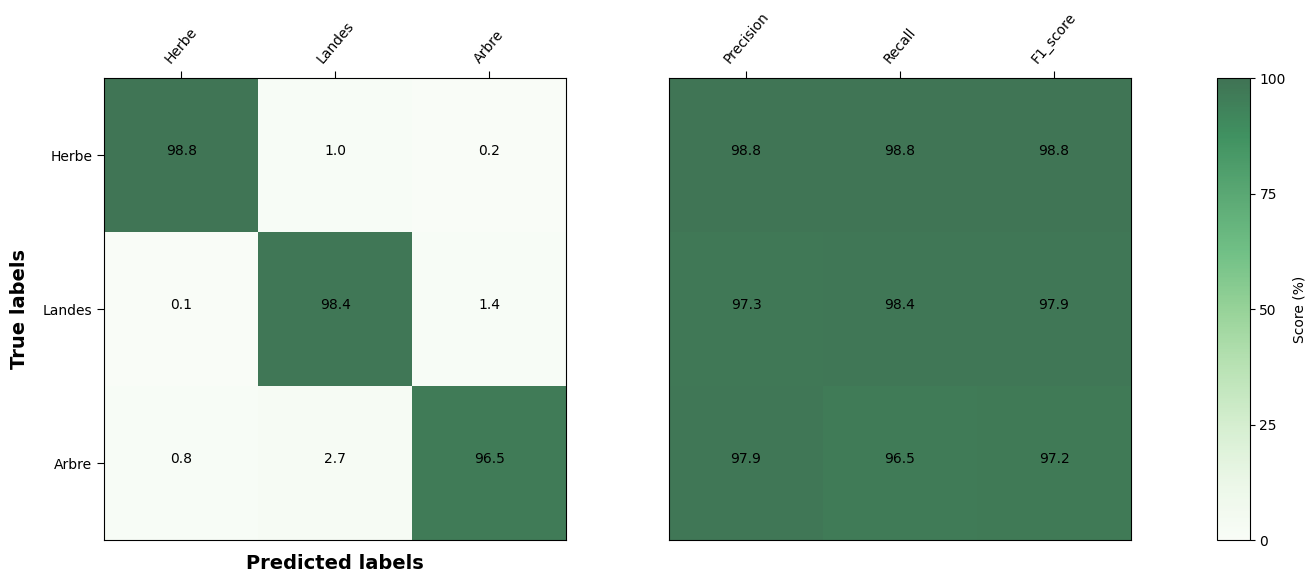

In [ ]:
array_cm = np.array(list_cm)
sum_cm = array_cm.sum(axis=0)

labels = ["Herbe", "Landes", "Arbre"]

plots.plot_cm(
    sum_cm,
    labels,
    out_filename=sortie_matrix,
    normalize=True
)

print("✅ Matrice de confusion sauvegardée :", sortie_matrix)


### Tableau des rapports moyens

In [71]:
a_report = list_report[0]

mean_df_report = pd.DataFrame(
    mean_report,
    index=a_report.index,
    columns=a_report.columns
)

std_df_report = pd.DataFrame(
    std_report,
    index=a_report.index,
    columns=a_report.columns
)

display(mean_df_report)
display(std_df_report)



,precision,recall,f1-score,support
2,0.990238,0.986294,0.988244,204.400000
3,0.972133,0.978109,0.975086,319.800000
4,0.971140,0.966329,0.968667,243.600000
accuracy,0.976554,0.976554,0.976554,0.976554
macro avg,0.977837,0.976911,0.977332,767.800000
weighted avg,0.976634,0.976554,0.976552,767.800000


,precision,recall,f1-score,support
2,0.007444,0.004809,0.004696,0.489898
3,0.011645,0.005938,0.007806,0.400000
4,0.009889,0.017504,0.012017,0.489898
accuracy,0.007601,0.007601,0.007601,0.007601
macro avg,0.007031,0.007641,0.007348,0.400000
weighted avg,0.007551,0.007601,0.007606,0.400000


La classe Herbe présente les meilleures performances avec un F1-score moyen de 0.98, traduisant une très bonne séparabilité spectrale.

La classe Landes obtient également de très bons résultats (F1 ≈ 0.95), bien que légèrement inférieurs, ce qui s’explique par des confusions ponctuelles avec la classe Arbre.

La classe Arbre montre un F1-score moyen de 0.94, avec un rappel légèrement supérieur à la précision, indiquant que certains pixels de landes sont parfois classés comme arbres.

Les écarts-types faibles confirment la stabilité du modèle vis-à-vis du découpage des données d’apprentissage.

### Graphique des résultats

✅ Matrice de confusion moyenne sauvegardée : /home/onyxia/work/results/figure/matrice_confusion.png
✅ Graphique qualité des classes sauvegardé : /home/onyxia/work/results/figure/qualite_classes.png


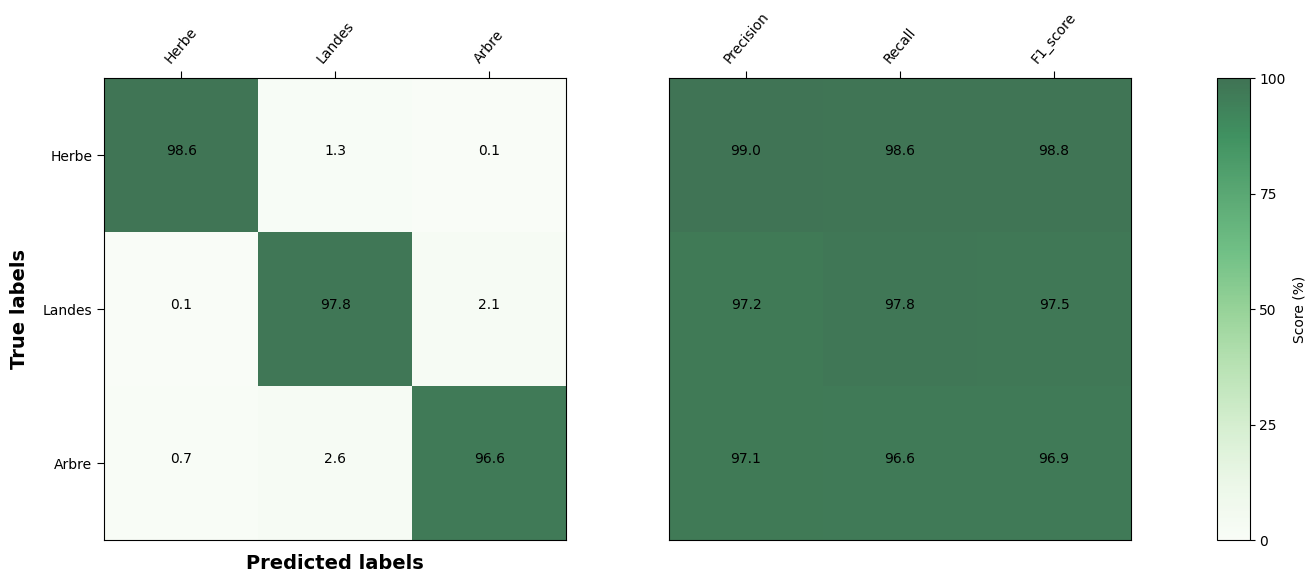

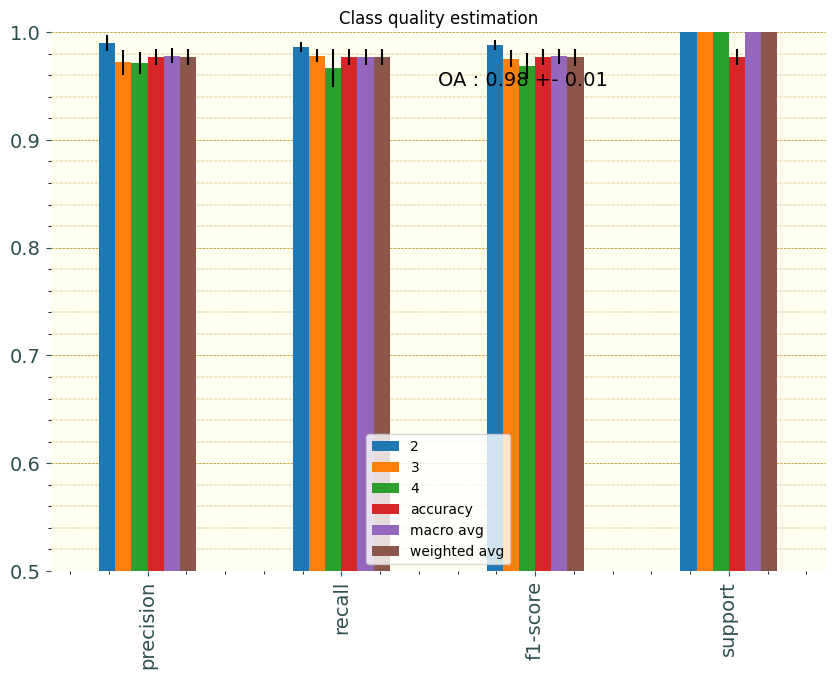

In [72]:
from libsigma import plots
import numpy as np

# =========================
# Matrice de confusion moyenne
# =========================

array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

labels = ["Herbe", "Landes", "Arbre"]

plots.plot_cm(
    mean_cm,
    labels,
    out_filename=sortie_matrix,
    normalize=True
)

print("✅ Matrice de confusion moyenne sauvegardée :", sortie_matrix)


# =========================
# Qualité moyenne des classes
# =========================

plots.plot_mean_class_quality(
    list_report,
    list_acc,
    out_filename=sortie_qualite
)

print("✅ Graphique qualité des classes sauvegardé :", sortie_qualite)


### Carte finale

In [73]:
from osgeo import gdal
import numpy as np
from libsigma import read_and_write as rw

# =========================
# Chargement image multibande
# =========================

multi_band_image_classification = out_stack

image_to_be_classified = rw.load_img_as_array(multi_band_image_classification)

rows, cols, bands = image_to_be_classified.shape
print("Image shape :", image_to_be_classified.shape)

# =========================
# Mise en forme pour classification
# =========================

X_image_to_be_classified = image_to_be_classified.reshape(rows * cols, bands)

# =========================
# Prédiction pixel par pixel
# =========================

y_pred = best_model.predict(X_image_to_be_classified)

# =========================
# Reconstruction image classifiée
# =========================

classified_image = y_pred.reshape(rows, cols)

# =========================
# Sauvegarde raster final
# =========================

sortie_classif = "/home/onyxia/work/results/carte_strates.tif"

ds_ref = gdal.Open(multi_band_image_classification)
driver = gdal.GetDriverByName("GTiff")

ds_out = driver.Create(
    sortie_classif,
    cols,
    rows,
    1,
    gdal.GDT_Byte   # uint8
)

ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

band = ds_out.GetRasterBand(1)
band.WriteArray(classified_image.astype(np.uint8))
band.SetNoDataValue(0)

ds_out = None
ds_ref = None

print("✅ Carte finale créée :", sortie_classif)


Image shape : (612, 1533, 60)
✅ Carte finale créée : /home/onyxia/work/results/carte_strates.tif


### Vérification nodata

In [74]:
ds = gdal.Open(sortie_classif)
band = ds.GetRasterBand(1)
print("Valeur NoData :", band.GetNoDataValue())
ds = None


Valeur NoData : 0.0
